Biobert 
Al igual que proteinBert trabaja con la arquitectura de Bert, representaciones de codificadores bidireccionales a partir de transformadores.
Transformadores: Los transformadores procesan secuencias largas en su totalidad con cálculo paralelo, lo que reduce significativamente.
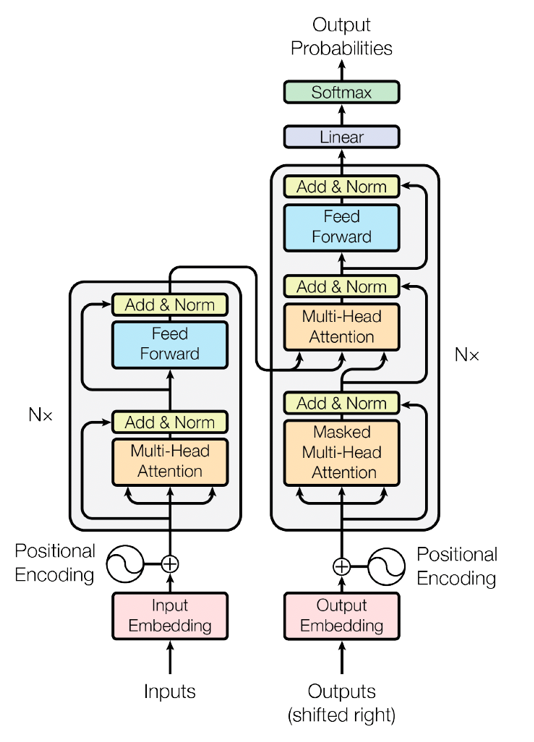

In [1]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch

#Al igual que en ProteinBert se necesitan BertTokenizer + BertModel: transformar secuencias en embeddings con ProtBert. torch: backend para cálculos y uso de GPU/CPU.

In [2]:
#Cargar el archivo
csv_file = "/Users/ingridreyes/Desktop/protein_descriptions_10000.csv"
bio_df = pd.read_csv(csv_file)

In [3]:
#solo quedarnos con la columna description
bio_df = bio_df.dropna(subset=['description'])

In [4]:
#cambiamos al cpu de Mac (:
if torch.backends.mps.is_available():
    device = torch.device("mps")   
else:
    device = torch.device("cpu")

In [5]:
#https://huggingface.co/dmis-lab/biobert-base-cased-v1.1
biobert_model_name = "dmis-lab/biobert-base-cased-v1.1"
biobert_tokenizer = BertTokenizer.from_pretrained(biobert_model_name)
biobert_model = BertModel.from_pretrained(biobert_model_name)
biobert_model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [6]:
def biobert_batch_embeddings(texts, batch_size=16, max_length=128):
    embeddings = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        if len(batch_texts) == 0:
            continue
        
        encoding = biobert_tokenizer(
            batch_texts,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=max_length
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        
        with torch.no_grad():
            outputs = biobert_model(input_ids=input_ids, attention_mask=attention_mask)
            batch_embeds = outputs.last_hidden_state.mean(dim=1).cpu()
        
        embeddings.append(batch_embeds)
    
    if len(embeddings) == 0:
        raise ValueError
            
    embeddings = torch.cat(embeddings, dim=0)
    return embeddings

In [7]:
bio_embeddings = biobert_batch_embeddings(bio_df['description'].tolist(), batch_size=16)

In [8]:
bio_df_emb = pd.DataFrame(bio_embeddings.numpy(), index=bio_df.index)
bio_df_emb.to_csv("/Users/ingridreyes/Desktop/embeddings_10000_biobert.csv")
print(f"completado: {len(bio_df_emb)}")

completado: 10000
